In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Scientific Computing
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats

import bottleneck as bn

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import gsw

from deformtools.tools import *
from deformtools.io import *
from deformtools.methods import *

# sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as  ttplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.4)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [79]:
def monte_carlo(L, skew,M, N):
    f = gsw.f(17)
    
    # make polygons
    xi, yi = make_n_hexs(L, skew, N, M)

    # find the u,v at the polygon vertices
    ui = fu.ev(xi, yi)
    vi = fv.ev(xi, yi)
    
    # find zeta at polygon center
    true2 = fzeta.ev(bn.nanmean(xi, axis=1), bn.nanmean(yi, axis=1))/f
#     true2 = np.nanmean( fzeta.ev(xi, yi), axis=1)/f

    estimate = np.zeros(N)
    for i in range(N):
        estimate[i], _, _ = least_square_method(
            xi[i, :], yi[i, :], ui[i, :], vi[i, :], 'lstsq')
        
    # compute R2 and confidence interval
    return stats.pearsonr(true2, estimate)[0]**2

In [80]:
# %% MAIN
data_path = '../../data/'
zgrid_path = data_path+'psom/zgrid.out'
model_path = data_path+'psom/full_08325.cdf'

# dat = read_model_field(snakemake.input[0], snakemake.input[1])
dat = read_model_field(zgrid_path, model_path) 
dat = dat.rename({'xc':'x'}).rename({'yc':'y'})
dat = dat.set_coords({'x','y'}).transpose('x','y')

fu_list, fv_list, fzeta_list = filter_fields(dat)

In [81]:
fu=fu_list[0]
fv=fv_list[0]
fzeta=fzeta_list[0]

In [82]:
llist = np.arange(1, 31, 1).astype(float)
llist = np.insert(llist, 0, 0.5)
mlist = np.arange(3, 11)
skewlist = np.logspace(0, 0.7, 30)

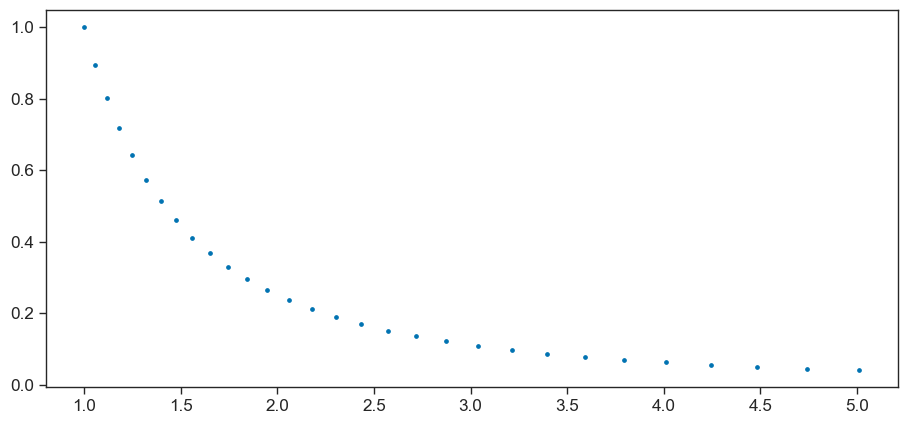

In [83]:
def check_aspect(L, skew,M, N):
    xi, yi = make_n_hexs(L, skew, N, M)
    return calc_aspect(xi[0, :], yi[0, :])

aspects =np.zeros(skewlist.size)
for si,s in enumerate(skewlist):
    aspects[si] = check_aspect(1,s,3,500)
    
plt.plot(skewlist, aspects  , '.')

In [84]:
results =np.zeros((llist.size, mlist.size))
s=1
for li,l in enumerate(llist):
    for mi,m in enumerate(mlist):
        results[li,mi] = monte_carlo(l,s,m,1000)

In [85]:
results1 =np.zeros((llist.size, skewlist.size))
m=3
for li,l in enumerate(llist):
    for si,s in enumerate(skewlist):
        results1[li,si] = monte_carlo(l,s,m,1000)

In [86]:
results2 =np.zeros((mlist.size, skewlist.size))
l=3
for mi,m in enumerate(mlist):
    for si,s in enumerate(skewlist):
        results2[mi,si] = monte_carlo(l,s,m,1000)

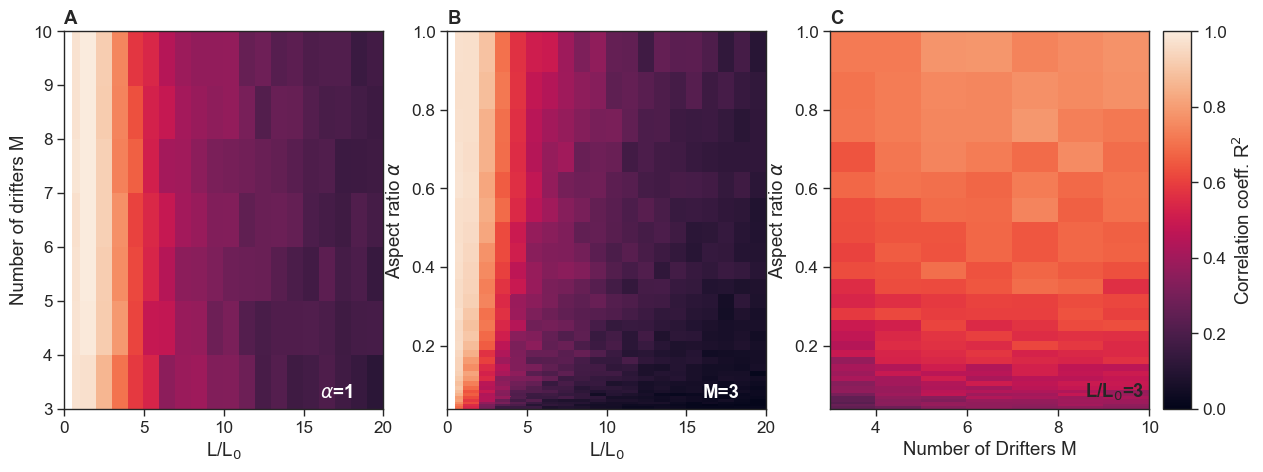

In [87]:
f, ax = plt.subplots(1,3, figsize=(14,5))
v = np.linspace(0, 0.4, 11, endpoint=True)

h= ax[0].pcolor(llist, mlist, results.T, vmin=0, vmax=1)
# plt.colorbar(h, ax=ax[0])
ax[0].set_xlabel(r'L/L$_0$')
ax[0].set_ylabel('Number of drifters M')
ax[0].set_xlim(0,20)

h = ax[1].pcolor(llist,aspects,results1.T, vmin=0, vmax=1)
# plt.colorbar(h, ax=ax[1])

ax[1].set_xlabel(r'L/L$_0$')
ax[1].set_ylabel(r'Aspect ratio $\alpha$')
ax[1].set_xlim(0,20)

h = ax[2].pcolor(mlist,aspects,results2.T, vmin=0, vmax=1)
# plt.colorbar(h, ax=ax[2]
a = ax[2].get_position() # pos left, bottom, width, height
cbar_ax = f.add_axes([a.bounds[0]+a.bounds[2]+0.01, a.bounds[1], 0.02, a.bounds[3] ]) #
cbar = f.colorbar(h, cax=cbar_ax,label=r'Correlation coeff. R$^2$') #,ticks=np.arange(0,1,10),')
# cbar.ax.set_xticklabels(np.arange(0,1,10))

ax[2].set_xlabel('Number of Drifters M')
ax[2].set_ylabel(r'Aspect ratio $\alpha$')

ax[0].annotate(r'$\alpha$=1',(0.8,0.03),xycoords='axes fraction',weight='bold', color='w')
ax[1].annotate('M=3',(0.8,0.03),xycoords='axes fraction',weight='bold', color='w')
ax[2].annotate(r'L/L$_0$=3',(0.8,0.03),xycoords='axes fraction',weight='bold')


alphabet(ax)

plt.savefig('../../figures/sensitivity_v2.pdf',bb_inches='tight',dpi=600)